In [1]:
%load_ext itikz
import itikz
from itikz import nicematrix_dev as nM
import jinja2

import panel as pn ; pn.extension()
import holoviews as hv; hv.extension('bokeh')
import numpy as np
import sympy as sym

import os
import tempfile
from pathlib import Path

from IPython.display import display
import logging
class JupyterHandler(logging.Handler):
    def _get_jupyter_level(self, level):
        level_name = logging.getLevelName(level)
        return level_name.lower()
        
    def emit(self, record):
        message = self.format(record)
        data = {
            'application/vnd.jupyterlab.log': {
                'type': 'text',
                'data': message,
                'level': self._get_jupyter_level(record.levelno)
            }
        }
        display(data, raw=True)

rootLogger = logging.getLogger()

rootLogger.setLevel(logging.INFO)
handler = JupyterHandler()
handler.setLevel(logging.INFO)
rootLogger.addHandler(handler)

#rootLogger.warning("HI")

In [2]:
np.random.seed(112244)
def gen_matrix(m,n):
    return np.random.randint( low=1,high=9, size=(m,n))

A0 = None;             A1 = gen_matrix(2,3); A2=gen_matrix(3,2);   A3=gen_matrix(2,1)
B0 = gen_matrix(2,2);  B1 = B0 @ A1;         B2= B1 @ A2;          B3=B2 @ A3
#C0 = gen_matrix(1,2);  C1 = C0 @ B1;         C2= C1 @ B2

#      -   (2,3) (3,2)   => COLS:  2 3 2
#    (2,2) (2,3) (2,2)   => ROWS:  3 2

layers=[ [A0, A1, A2, A3],
         [B0, B1, B2, B3],
       ]

# MatrixGridLayout

In [3]:
#%load itikz/nicematrix.py

| | | | |
| --- | --- | --- | --- |
|     |       | y y |   |
|     | x x x | y y |z |
|     | x x x | y y |z |
| a a | * * * | * * |# |
| a a | * * * | * * |# |

In [3]:
def testMatrixGridLayout():
    mm = nM.MatrixGridLayout(layers, extra_cols=[1,0,0,0,3], extra_rows=[0,0,0])
    mm.describe()
    print()
    #print( 'no partition:', MatrixGridLayout.matrix_array_format( 5 ))
    #print( 'partition:   ', MatrixGridLayout.matrix_array_format( 5, vpartitions=[1,3,4] ))
    #print()
    print('Top Left : Bottom Right Corners')
    for i in range(mm.nGridRows):
        for j in range(mm.nGridCols):
            tl,br,_ = mm._top_left_bottom_right(i,j)
            print( f"  {tl}:{br}", end='')
        print()
    # ====================================================================
    # Process the Matrix Grid for Display
    # ====================================================================
    mm.array_format_string_list( partitions={ 1:[2], 2:[1], 3:[1]}, spacer_string=r'@{\hspace{5mm}}' )
    mm.array_of_tex_entries()
    mm.nm_submatrix_locs()

    if True:
        red   = nM.make_decorator( text_color='red' )    
        boxbf = nM.make_decorator( boxed=True, bf=True)
        bg    = nM.make_decorator( text_bg="red!15")

        mm.decorate_tex_entries( 0,3, red,   entries=None )
        mm.decorate_tex_entries( 1,2, boxbf, entries= [(1,0),(0,1)])
        mm.decorate_tex_entries( 1,1, bg,    entries=[(0,0),(1,1)] )

    #mm.decorate_tex_entries( 1,2, lambda a: '\\boxed{{ {a} }}'.format(a=a), entries= [(1,0),(0,1)])

    mm.tex_repr( blockseps = r'[3mm]') # r'\noalign{\vskip2mm} ')

    # ====================================================================

    print("% -------------------------------------")
    print(f"format: {mm.format}");
    print("% -------------------------------------")
    print("LaTeX representation of the matrix")
    for l in mm.tex_list:
        print(l)
    print("% -------------------------------------")
    print("Submatrices:", mm.locs )
    print("% -------------------------------------")

    return mm

# Example mX: Single Matrix, Extra Rows

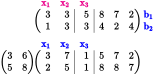

In [4]:
mX = nM.MatrixGridLayout([[None, gen_matrix(2,6)],[gen_matrix(2,2), gen_matrix(2,6)]], extra_cols=1, extra_rows=[1,1,0])
mX.array_format_string_list( partitions={ 1:[2,1]}, spacer_string=r'@{\hspace{5mm}}', last_col_format=r'l@{\hspace{2.5cm}}' )
mX.array_of_tex_entries()

mX.add_row_above(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{magenta}}{{\\mathbf{{ {a} }}}}'.format(a=a))
mX.add_row_below(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

mX.add_col_right(0,1,['b_1','b_2'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

mX.nm_submatrix_locs()


mX.tex_repr( blockseps = r'[2mm]')
mX_code = mX.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        mX_code, prefix='mX_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/mX" )
h

# Example m1

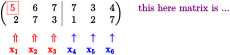

In [5]:
m1 = nM.MatrixGridLayout(gen_matrix(2,6), extra_cols=1, extra_rows=2)
m1.array_format_string_list( partitions={ 1:[3]}, spacer_string=r'@{\hspace{5mm}}' )
m1.array_of_tex_entries()
m1.decorate_tex_entries( 0,1, lambda a: '\\color{{red}}{{ \\boxed{{{a}}} }}'.format(a=a), entries=[(0,0)] )

blue = nM.make_decorator(text_color='blue', bf=True)
red  = nM.make_decorator(text_color='red',  bf=True)

typ = [red(r'\Uparrow'),red(r'\Uparrow'),red(r'\Uparrow'),blue(r'\uparrow'),blue(r'\uparrow'),blue(r'\uparrow')]
var = [red('x_1'),      red('x_2'),      red('x_3'),      blue('x_4'),      blue('x_5'),      blue('x_6')]

m1.add_row_below(0,1,typ, formater=lambda a: a )
m1.add_row_below(0,1,var, offset=1, formater=lambda a: a )

m1.nm_text( ['this here matrix is ...'])
m1.nm_submatrix_locs()
m1.tex_repr( blockseps = r'\noalign{\vskip2mm} ')

m1_code = m1.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m1_code, prefix='m1_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/m1" )
h

# Example m2

In [6]:
m2=testMatrixGridLayout()

Layout 2 x 4 grid:
.  insert extra_cols:            [1, 0, 0, 0, 3]
.  col_start                   = [ 1  3  6  8 12]
.  row_start                   = [0 3 5]

Consistent Matrix Sizes in the grid
  (3, 2)  (3, 3)  (3, 2)  (3, 1)
  (2, 2)  (2, 3)  (2, 2)  (2, 1)
Actual TopLeft:BottomRight Indices
  (3, 3):(2, 2)  (1, 3):(2, 5)  (0, 6):(2, 7)  (1, 8):(2, 8)
  (3, 1):(4, 2)  (3, 3):(4, 5)  (3, 6):(4, 7)  (3, 8):(4, 8)

Top Left : Bottom Right Corners
  (3, 3):(2, 2)  (1, 3):(2, 5)  (0, 6):(2, 7)  (1, 8):(2, 8)
  (3, 1):(4, 2)  (3, 3):(4, 5)  (3, 6):(4, 7)  (3, 8):(4, 8)
% -------------------------------------
format: r@{\hspace{5mm}}*2r@{\hspace{5mm}}*2rI*1r@{\hspace{5mm}}*1rI*1r@{\hspace{5mm}}*1rI@{\hspace{5mm}}rrl@{\hspace{2cm}}
% -------------------------------------
LaTeX representation of the matrix
 &  &  &  &  &  & 1 & 2 &  &  &  &  \\
 &  &  & 7 & 5 & 6 & 4 & 3 & \color{red}{3} &  &  &  \\
 &  &  & 4 & 8 & 1 & 2 & 5 & \color{red}{5} &  &  &  \\m]
 & 4 & 7 & \Block[draw=black,fill=

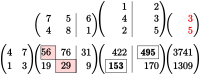

In [8]:
m2_latex_doc = m2.nm_latexdoc(template = nM.GE_TEMPLATE )

h = itikz.fetch_or_compile_svg(
        m2_latex_doc, prefix='tst_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=1, keep_file="tmp/m2" )
h

# Example m3

In [9]:
k  = sym.Symbol('k'); h = sym.Symbol('h')
Ab = sym.Matrix([[1,2,4,1],[2,k,8,h],[3,7,3,1]]); matrices = [[None, Ab]]; pivots = []; txt=[]
# we could use row ops, but we want a computational layout (and hence the E matrices!):
#    A=A.elementary_row_op('n->n+km', k=-3, row1=2,row2=0 );A
#    A=A.elementary_row_op('n<->m',row1=1,row2=2);A

E1=sym.eye(3);E1[1:,0]=[-2,-3]; A1=E1*Ab;                               matrices.append([E1,A1]); pivots.append((1,1));txt.append('Pivot at (1,1)')
E2=sym.eye(3);E2=E2.elementary_row_op('n<->m',row1=1,row2=2); A2=E2*A1; matrices.append([E2,A2]); pivots.append(None); txt.append('Rows 2 <-> 3')
E3=sym.eye(3);E3[2,1]=4-k; A3=E3*A2;                                    matrices.append([E3,A3]); pivots.append((2,2));txt.append('Pivot at (2,2)')
pivots.append((3,3)); txt.append('In Row Echelon Form')

if False:
    mat_rep, submatrix_locs, pivot_locs, path_corners, txt_with_locs,mat_format = \
       nM.ge_layout( matrices, Nrhs=1, pivots=pivots, txt=txt, decorate=True,\
                     formater=lambda x: sym.latex(x))

    mat_options = r"""[ code-before =
        {
        % ----------------------------------------------------------------------- Row-echelon form Path
        \tikz \draw[red] """ + " -- ".join( path_corners )+ " ; } ]"

    h =\
    itikz.fetch_or_compile_svg( jinja2.Template( nM.GE_TEMPLATE ).render( preamble=nM.preamble, extension=nM.extension,
                                                                          mat_rep=mat_rep, mat_format=mat_format, mat_options=mat_options,
                                                                          submatrix_locs=submatrix_locs, pivot_locs=pivot_locs, txt_with_locs=txt_with_locs),
                                prefix='sol_rhs_', working_dir='/tmp/itikz', debug=False,
                                **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True), nexec=4, keep_file="/tmp/foo" )
    display(h)

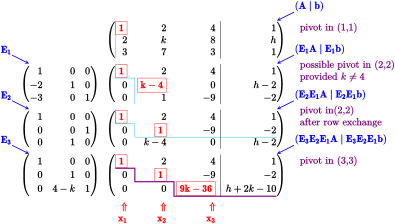

In [10]:
h,m = nM.ge( matrices, Nrhs=[1],
             formater = sym.latex,
             pivot_list=[ [(0,1), [(0,0)] ],
                          [(1,1), [(0,0),(1,1)]],
                          [(2,1), [(0,0),(1,1)]],
                          [(3,1), [(0,0),(1,1),(2,2)]]
                          ],
             ref_path_list = [ [0,1, [(0,0)            ],'vv','cyan'],
                               [1,1, [(0,0),(1,1)      ],'hv','cyan'],
                               [2,1, [(0,0),(1,1)      ],'vh','cyan'],
                               [3,1, [(0,0),(1,1),(2,2)],'hh']
                             ],
             comment_list = ["pivot in (1,1)",
                             r"possible pivot in (2,2) \\ \qquad provided $k \ne 4$",
                             r"pivot in(2,2)\\ \qquad after row exchange","pivot in (3,3)"],  # <===== ???? Where are they?
             variable_summary = [True,True,True],
             array_names = ['E', ['A', 'b']],
             tmp_dir="tmp", keep_file="tmp/m3"
)
h

In [11]:
m.rowechelon_paths=[]
m.submatrix_name = 'A'

def nm_add_rowechelon_path( self, gM,gN, pivots, case='hh', color='red' ):
        tl,_,shape = self._top_left_bottom_right( gM, gN )
        
        # --------------------------------------------- # add the end point
        if (case=='vh') or (case=='hh'):                #   last dir: ->
            pivots.append( (pivots[-1][0]+1,shape[1]))  #     we end in current row+1, last col
        else:                                           #   last dir: |
            pivots.append( (shape[0],pivots[-1][1]))    #     we end in current col, last row

        # --------------------------------------------- # obtain the corner positions
        if (case == 'vh') or (case == 'vv'):            # first motion is vertical: go down 1 row
            cur = pivots[0]                             #   since we move vertically, start at cur north east
        else:                                           # first move is horizontal
            cur = (pivots[0][0]+1, pivots[0][1])        #   since we move horizontally, start at cur south east

        ll  = [ cur ]           
        for nxt in pivots[1:]:
            if nxt[1] != cur[1]:                        # next entry is in  a different column: first go down to its row
                ll.append( (nxt[0],cur[1]) )
            ll.append( nxt )                            # now move horizontally to this entry
            cur = nxt

        # --------------------------------------------- # generate the tikz command
        if (case=='vh') or (case=='hh'):                #   last dir: ->
            i,j = ll[-2]
            pos = f'let \\p1 = ({self.submatrix_name}{gM}x{gN}.south east), \\p2 = ({i+tl[0]+1}-|{j+tl[1]+1}) in '
            end =  r' -- (\x2,\y1) -- (\x1,\y1);'
            ndx = -2
        else:                                           #   last dir: |
            i,j = ll[-1]
            pos = f'let \\p1 = ({self.submatrix_name}{gM}x{gN}.south west), \\p2 = ({i+tl[0]+1}-|{j+tl[1]+1}) in '
            end = r' -- (\x2,\y1);'
            ndx = -1

        cmd = '\\tikz \\draw['+color+']    ' + pos + ' -- '.join( [f'({i+tl[0]+1}-|{j+tl[1]+1})' for (i,j) in ll[:ndx]]) + end
        self.rowechelon_paths.append( cmd )

m.nm_add_rowechelon_path( 0,1, [(0,0)            ],'vv','blue,line width=0.6mm')
m.nm_add_rowechelon_path( 1,1, [(0,0),(1,1)      ],'hv','blue,line width=0.6mm')
m.nm_add_rowechelon_path( 2,1, [(0,0),(1,1)      ],'vh','cyan,line width=0.6mm')
m.nm_add_rowechelon_path( 3,1, [(0,0),(1,1),(2,2)],'hh','blue,line width=0.6mm')

for tikz in m.rowechelon_paths: print(tikz)

\tikz \draw[blue,line width=0.6mm] let \p1 = (A0x1.north west), \p2 = (A0x1.south east), \p3 = (4-|4), \p4 = (4-|4) in (\x1,\y1) -- (\x4,\y2);
\tikz \draw[blue,line width=0.6mm] let \p1 = (A1x1.north west), \p2 = (A1x1.south east), \p3 = (5-|4), \p4 = (7-|5) in (\x1,\y3) -- ($ (5-|5) + (0.1,0) $) -- ($ (\x4,\y2) + (0.1,0) $);
\tikz \draw[cyan,line width=0.6mm] let \p1 = (A2x1.north west), \p2 = (A2x1.south east), \p3 = (8-|4), \p4 = (9-|5) in (\x1,\y1) -- (\x1,\y3) -- ($ (8-|5) + (0.1,0) $) -- ($ (9-|5) + (0.1,0) $) -- (\x2,\y4);
\tikz \draw[blue,line width=0.6mm] let \p1 = (A3x1.north west), \p2 = (A3x1.south east), \p3 = (11-|4), \p4 = (13-|6) in (\x1,\y3) -- ($ (11-|5) + (0.1,0) $) -- ($ (12-|5) + (0.1,0) $) -- ($ (12-|6) + (0.1,0) $) -- ($ (\x4,\y2) + (0.1,0) $) -- (\x2,\y2);


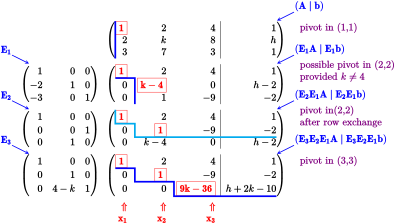

In [12]:
m_code = m.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
    m_code, prefix='ge_', working_dir="tmp", debug=False,
    **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
    nexec=1, keep_file='tmp/tst' )
h

# Fancy QR Example

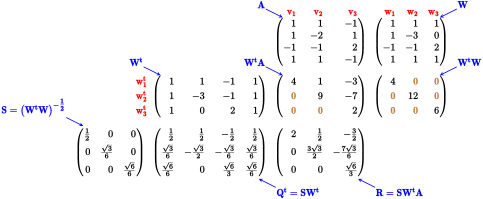

In [14]:
A = sym.Matrix([[ 1,  1, -1],
                [ 1, -2,  1],
                [-1, -1,  2],
                [ 1,  1, -1]])
W = sym.Matrix([[ 1,  1,  1],
                [ 1, -3,  0],
                [-1, -1,  2],
                [ 1,  1,  1]])

WtW  = W.T @ W
WtA  = W.T @ A
S    = WtW**(-1)
for i in range(S.shape[0]):
    S[i,i]=sym.sqrt(S[i,i])

Qt = S*W.T
R  = S*WtA

matrices =  [ [ None,  None,   A,    W ],
              [ None,   W.T, WtA,  WtW ],
              [ S,       Qt,   R, None ] ]

def nM_qr(matrices, formater=repr , array_names=True, scale=0.5, tmp_dir=None, keep_file=None):
    mZ = nM.MatrixGridLayout( matrices, extra_rows = [1,0,0,0])

    mZ.array_format_string_list()
    mZ.array_of_tex_entries(formater=formater)

    brown    = nM.make_decorator(text_color='brown', bf=True )
    def qr_dec_known_zeros( WtA, WtW ):
        l_WtA = [(1,2), [(i,j) for i in range(WtA.shape[0]) for j in range(WtA.shape[0]) if i >  j ]]
        l_WtW = [(1,3), [(i,j) for i in range(WtW.shape[0]) for j in range(WtW.shape[0]) if i != j ]]
        return  [l_WtA, l_WtW]

    for spec in qr_dec_known_zeros(WtA, WtW):
        #[ [(1,2), [(1,0),(2,0),(2,1)]], [(1,3), [(1,0),(2,0),(2,1), (0,1),(0,2),(1,2)]] ]:
        mZ.decorate_tex_entries( *spec[0], brown, entries=spec[1] )

    red      = nM.make_decorator(text_color='red',  bf=True)
    red_rgt  = nM.make_decorator(text_color='red',  bf=True, move_right=True)
    mZ.add_row_above(0,2, [red(f'v_{i+1}')   for i in range(3)] + [red(f'w_{i+1}') for i in range(3)], formater= lambda a: a )
    mZ.add_col_left( 1,1, [red_rgt(f'w^t_{i+1}') for i in range(3)], formater= lambda a: a )

    if array_names:
        dec = nM.make_decorator(bf=True, delim='$')
        mZ.nm_submatrix_locs( 'QR', color='blue', name_specs=[
            [(0,2), 'al', dec('A')],
            [(0,3), 'ar', dec('W')],
            # ----------------------
            [(1,1), 'al', dec('W^t')],
            [(1,2), 'al', dec('W^t A')],
            [(1,3), 'ar', dec('W^t W')],
            # ----------------------
            [(2,0), 'al', dec(r'S = \left( W^t W \right)^{-\tfrac{1}{2}}')],
            [(2,1), 'br', dec(r'Q^t = S W^t')],
            [(2,2), 'br', dec('R = S W^t A')]
        ] )
    else:
        mZ.nm_submatrix_locs()

    mZ.tex_repr( blockseps = r'\noalign{\vskip3mm} ')

    mZ.preamble = nM.preamble + r" \NiceMatrixOptions{cell-space-limits = 2pt}"
    mZ_code = mZ.nm_latexdoc( fig_scale=scale )

    h = itikz.fetch_or_compile_svg(
            mZ_code, prefix='qr_', working_dir=tmp_dir, debug=False,
            **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
            nexec=1, keep_file=keep_file )
    return h, mZ

#h,mz = nM.qr( matrices, formater=lambda x: '{0:.8f}'.format(float(x)), array_names=True, fig_scale=0.7, tmp_dir="/tmp", keep_file='/tmp/qr')
h,mz = nM.qr( matrices, formater=sym.latex, array_names=True, tmp_dir="tmp", keep_file='tmp/qr_fancy')
h

# Matrix Stacks

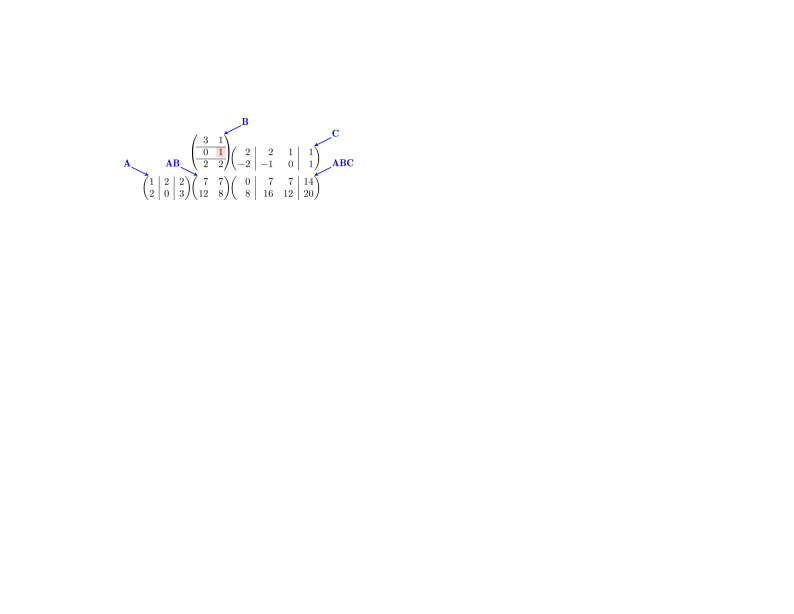

In [40]:
A   = np.array( [[1,2,2],[2,0,3]])
B   = np.array( [[3,1],[0,1],[2,2]])
C   = np.array( [[2,2,1,1],[-2,-1,0,1]])
AB  = A @ B
ABC = AB @ C

matrices=[[None, B, C],[A, AB, ABC]]
m_lr = nM.MatrixGridLayout(matrices, extra_cols=1, extra_rows=2)
m_lr.array_format_string_list( spacer_string=r'@{\hspace{5mm}}', last_col_format=r'l@{\hspace{2.0cm}}',
                              partitions={2:[1,3]},
                             )
m_lr.array_of_tex_entries()

dec = nM.make_decorator(bf=True, delim='$')
m_lr.nm_submatrix_locs( 'PROD', color='blue', name_specs=[
            [(0,1), 'ar', dec('B')],
            [(0,2), 'ar', dec('C')],
            # ----------------------
            [(1,0), 'al', dec('A')],
            [(1,1), 'al', dec('A B')],
            [(1,2), 'ar', dec('A B C')],
        ],
        line_specs = [
            [(0,1), [1,2], None],
            [(1,0), None, [1,2]]
        ]
        )

def foo(m):
    m.preamble = r'\tikzset{highlight/.style = { fit = #1 , fill=red!15, blend mode = multiply , inner sep = 2pt } }' +\
                 '\n' +\
                 r'\tikzset{erase/.style = { fit = #1 , fill=Olive!90!Fuchsia, blend mode = multiply , inner sep = 2pt } }'
    m.rowechelon_paths.append( f'\\node [highlight = (2-5)] {{ }} ;')
    #for k in ['(4-1) (4-3)','(5-3)', '(1-5) (3-5)']:
    #    m.rowechelon_paths.append( f'\\node [highlight = {k}] {{ }} ;')
    #for k in ['(2-9) (3-9)','(4-9) (5-9)', '(4-4) (5-4)']:
    #    m.rowechelon_paths.append( f'\\node [erase = {k}] {{ }} ;')
foo(m_lr)

#    dark = nM.make_decorator(text_color='Brown4',  bg_color='Green4!60')
#    m.codebefore.append(r'''\cellcolor{red!15}{1-6,2-9,2-12,3-11} ''')
#    m.codebefore.append(r'''\columncolor{blue!15}{3} ''')
#    m.decorate_tex_entries( 0,1, dark, entries=[(0,1),(1,1),(2,1)])
#    m.decorate_tex_entries( 1,0, dark, entries=[(0,0),(0,1),(0,2)])
#m_lr.apply(foo)
#foo(m_lr)

m_lr.tex_repr() # blockseps = r'\noalign{\vskip2mm} ')
#m_lr.preamble = r'\tikzset{highlight/.style = { fit = #1 , fill=red!15, blend mode = multiply , inner sep = 2pt } }'

m_lr_code = m_lr.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m_lr_code, prefix='abc_',
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=1,debug=False, working_dir="tmp", keep_file="tmp/abc_lr_pb" )
h

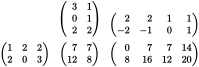

In [39]:
def foo(m):
    m.preamble = r'\tikzset{highlight/.style = { fit = #1 , fill=red!15, blend mode = multiply , inner sep = 2pt } }' +\
                 '\n' +\
                 r'\tikzset{erase/.style = { fit = #1 , fill=Olive!90!Fuchsia, blend mode = multiply , inner sep = 2pt } }'
    #m.rowechelon_paths.append( f'\\node [highlight = (2-5)] {{ }} ;')

    #m.format=r'@{\hspace{5mm}}*3r@{\hspace{5mm}}*1r*1r@{\hspace{5mm}}*4r'
    #dark = nM.make_decorator(text_color='Honeydew',  bg_color='Olive!90!Fuchsia')    Olive!80!DarkSlateGray
    #m.codebefore.append(r'''\cellcolor{red!16}{1-5,2-9} ''')
    #m.codebefore.append(r'''\columncolor{blue!15}{3} ''')
    #m.decorate_tex_entries( 0,1, dark, entries=[(0,0),(1,0),(2,0)])
    #m.decorate_tex_entries( 1,0, dark, entries=[(0,0),(0,1),(0,2)])
    #for k in ['(4-1) (4-3)','(5-3)', '(1-4) (3-5)']:
    #    m.rowechelon_paths.append( f'\\node [highlight = {k}] {{ }} ;')
    #for k in ['(2-9) (3-9)','(4-9) (5-9)', '(4-4) (5-4)']:
    #    m.rowechelon_paths.append( f'\\node [erase = {k}] {{ }} ;')

h,m=nM.ge(matrices, func=foo, keep_file="tmp/keep")
#print(m.format)
h

In [21]:
nrhs=[1,2]
print(m.mat_col_width)
cuts = [m.mat_col_width[-1] - sum(nrhs)]
print(cuts)
for cut in nrhs[1:]:
    cuts.append( cuts[-1]+cut )
print(cuts)

[3, 2, 4]
[1]
[1, 3]


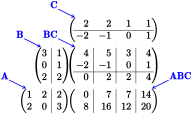

In [14]:
A = np.array( [[1,2,2],[2,0,3]])
B = np.array( [[3,1],[0,1],[2,2]])
C = np.array( [[2,2,1,1],[-2,-1,0,1]])
AB  = A @ B
ABC = AB @ C

matrices=[[None,C],[B, B@C], [A,ABC]]
m_td = nM.MatrixGridLayout(matrices, extra_cols=1, extra_rows=2)
m_td.array_format_string_list( spacer_string=r'@{\hspace{5mm}}',
                            last_col_format=r'l@{\hspace{2cm}}' )
m_td.array_of_tex_entries()

#m_td.add_horizontal_partition( 0,1,0,  (0,3))
#m_td.add_horizontal_partition( 1,1,1,  (0,3))

dec = nM.make_decorator(bf=True, delim='$')
m_td.nm_submatrix_locs( 'PROD', color='blue', name_specs=[
            [(0,1), 'al', dec('C')],
            # ----------------------
            [(1,0), 'al', dec('B')],
            [(1,1), 'al', dec('B C')],
            [(2,0), 'al', dec('A')],
            [(2,1), 'ar', dec('A B C')],
        ] ,
        line_specs = [
            [(0,1), 1, None],
            [(1,0), None, 1], [(1,1), 2,[1,2,3]],
            [(2,0), None, 2], [(2,1),None,[1,2,3]]
        ]
        )
m_td.tex_repr(blockseps = r'[2mm]') # blockseps = r'\noalign{\vskip2mm} ')
#m_td.add_horizontal_partitions( [[0,2,0,[0,4]] ])
m_td_code = m_td.nm_latexdoc()

if True:
    h = itikz.fetch_or_compile_svg(
    m_td_code, prefix='m_td_', working_dir="tmp", debug=False,
    **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
    nexec=1, keep_file="tmp/abc_td" )
h

<img src="tmp/foo.svg">